In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import demoji
from langdetect import detect, DetectorFactory
import re

In [2]:
df_comments = pd.read_pickle("../data/comments/all_comments.pkl")

In [3]:
# converting strings to datetime
df_comments['video_publish_date'] = pd.to_datetime(df_comments['video_publish_date'], format='%Y-%m-%dT%H:%M:%SZ')
df_comments['comment_publish_date'] = pd.to_datetime(df_comments['comment_publish_date'], format='%Y-%m-%dT%H:%M:%SZ')

# Extracting year, and month from the datetime column
# video
df_comments['video_year'] = df_comments['video_publish_date'].dt.year
df_comments['video_month'] = df_comments['video_publish_date'].dt.month

# comment
df_comments['comment_year'] = df_comments['comment_publish_date'].dt.year
df_comments['comment_month'] = df_comments['comment_publish_date'].dt.month

# define the fixed minimum date
min_date = pd.to_datetime('2017-01-01')

# Calculate the running month
df_comments['video_running_month'] = df_comments['video_month'] + 12 * (df_comments['video_year'] - min_date.year)
df_comments['comment_running_month'] = df_comments['comment_month'] + 12 * (df_comments['comment_year'] - min_date.year)

# Calculate the running days
df_comments['comment_running_days'] = (df_comments['comment_publish_date'] - min_date).dt.days

# filter comments after 90 days of videos' release
# Calculate the difference in days
df_comments['days_publish_date_difference'] = (df_comments['comment_publish_date'] - df_comments['video_publish_date']).dt.days

# Filter to include only comments within 90 days of the video publish date
df_timely_comments = df_comments[df_comments['days_publish_date_difference'] <= 90]

df_timely_comments = df_timely_comments.drop(columns='days_publish_date_difference')


In [4]:
# Save only timely comments to pickle format
df_timely_comments.to_pickle("../data/comments/timely_comments.pkl")

In [4]:
# Function to count words in a string
def word_count(text):
    return len(text.split())

# Filter out comments with less than 3 words
df_timely_comments = df_timely_comments[df_timely_comments['comment_text'].apply(word_count) >= 3]

#df_timely_comments.info()

## Text Cleaning

In [5]:
# Text Cleaning Functions

# remove all emojis
def remove_emojis(text):
    return demoji.replace(text, "")

# Function to normalize text (NOTE: If creating R dataframe, comment out the # Remove punctuations part)
def normalize_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)  # Remove @mentions
    text = re.sub(r"&quot;", "", text) # Remove instances of &quot;
    text = re.sub(r"&#39;", "'", text) # Replace all instances of &#39; with '
    text = re.sub(r"<[^>]*>", " ", text) # Remove all HTML tags
    text = re.sub(r"https?://[A-Za-z0-9./]+", " ", text)  # Remove URLs
    text = re.sub(r"https?", " ", text)  # Remove http/https
    text = re.sub(r'(.)\1+', r'\1', text)  # Remove repeated characters
    #text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    return text

# Function to detect if language is English
# ensure consistent results
DetectorFactory.seed = 0
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False



In [9]:
# Apply text cleaning functions (NOTE: If creating R Dataframe comment out the applicaton of remove_stop_words())
df_timely_comments['comment_text'] = df_timely_comments['comment_text'].apply(remove_emojis)
df_timely_comments['comment_text'] = df_timely_comments['comment_text'].apply(normalize_text)
df_timely_comments = df_timely_comments[df_timely_comments['comment_text'].apply(is_english)]


/var/folders/k1/f7fqjhfj6psgylqzzqh20nh80000gn/T/ipykernel_32696/571264365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timely_comments['comment_text'] = df_timely_comments['comment_text'].apply(remove_emojis)
/var/folders/k1/f7fqjhfj6psgylqzzqh20nh80000gn/T/ipykernel_32696/571264365.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timely_comments['comment_text'] = df_timely_comments['comment_text'].apply(normalize_text)


## Sample Comment for Presentation and Descriptive Statistics

In [10]:
sample_comment = "Elon: warning about A.I.<br>Also Elon: building a 5&#39;8 tesla A.I. 🙄"
sample_comment = remove_emojis(sample_comment)
sample_comment = normalize_text(sample_comment)


print(sample_comment)

Elon: warning about A.I. Also Elon: building a 5'8 tesla A.I. 


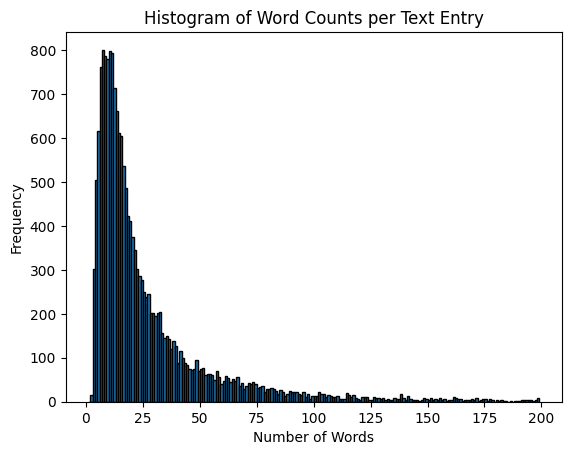

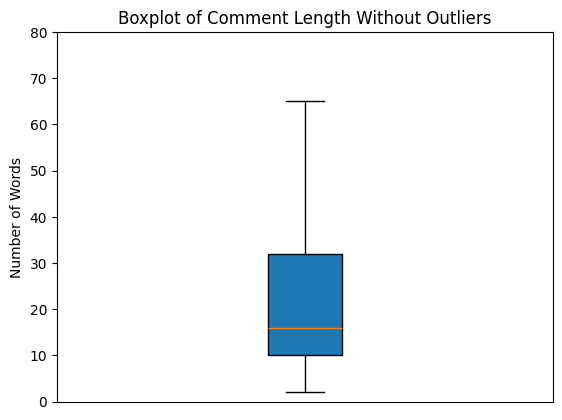

In [10]:
# Calculate the number of words per comment
df_descriptive_analysis = df_timely_comments
df_descriptive_analysis['word_count'] = df_descriptive_analysis['comment_text'].apply(lambda x: len(x.split()))

# Plot the histogram of the distribution of word length
plt.hist(df_descriptive_analysis['word_count'], bins=range(1, 200), edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts per Text Entry')
plt.show()

# Plot a boxplot showing mean, median and quartiles of comment length as well as outliers
plt.boxplot(df_descriptive_analysis['word_count'], patch_artist=True, showfliers=False)

# Customize x-axis labels
max_word_count = df_descriptive_analysis['word_count'].max()
plt.yticks(range(0, max_word_count + 10, 10))
plt.ylim(0, 80)
# Remove y-axis labels
plt.xticks([])

plt.ylabel('Number of Words')
plt.title('Boxplot of Comment Length Without Outliers')
plt.show()

In [8]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)  # Set the max column width to unlimited

# Apply the is_english() function to the 'comment_text' column
#df_timely_comments = df_timely_comments[df_timely_comments['comment_text'].apply(is_english)]
#print(df_timely_comments['comment_text'])


84       We laugh at Sofia now, but is just a mater of ...
103      this is a god begining of my plan to dominate ...
114      Do you know where you are Sophia? I'm in a dream.
115      this was totaly col.but Sophia was a litle bit...
122               At 4:58 why do people think it's a joke.
                               ...                        
77789    I found the info in this video interesting and...
77792    If you're that impresed by the humanoid robot ...
77793    While I do apreciate the story here, there are...
77796    I wanted to share this experience I had a few ...
77797    Thank you for this wonderful video! I have inc...
Name: comment_text, Length: 18505, dtype: object


In [11]:
df_filtered_text_cleaned = df_timely_comments
# Save df with cleaned text
df_filtered_text_cleaned.to_pickle("../data/comments/df-filtered_text-cleaned_comments.pkl")

In [31]:
df_filtered_text_cleaned = pd.read_pickle("../data/comments/df-filtered_text-cleaned_comments.pkl")

In [15]:
df_filtered_text_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18505 entries, 84 to 77797
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   video_id               18505 non-null  object        
 1   video_title            18505 non-null  object        
 2   video_publish_date     18505 non-null  datetime64[ns]
 3   video_category_id      18505 non-null  object        
 4   comment_text           18505 non-null  object        
 5   comment_id             18505 non-null  object        
 6   comment_publish_date   18505 non-null  datetime64[ns]
 7   video_year             18505 non-null  int32         
 8   video_month            18505 non-null  int32         
 9   comment_year           18505 non-null  int32         
 10  comment_month          18505 non-null  int32         
 11  video_running_month    18505 non-null  int32         
 12  comment_running_month  18505 non-null  int32         
 13  comme

## Filter Text with Keywords

In [16]:
# Define AI-related keywords
ai_keywords = [
    'artificial intelligence', 'ai', 'a.i.', 'a.i', 'a. i', 'a i.', 'a i', 'machine learning', 'ml', 
    'deep learning', 'neural networks', 'large language model', 'language model', 'supervised learning', 
    'unsupervised learning', 'self-driving', 'self driving', 'image recognition', 'speech recognition', 
    'automation', 'turing test', 'agi', 'artificial general intelligence', 'ani', 'artificial narrow intelligence', 
    'asi', 'artificial superintelligence', 'algorithm', 'intelligent agent', 'data mining', 'data science', 
    'computer science', 'intelligent system', 'predictive modeling', 'quantum computing', 'virtual assistant', 
    'bot', 'robot', 'gpt', 'bard', 'gemini', 'chatgpt', 'transformer', 'openai', 'dalle', 'stable diffusion', 
    'meta', 'microsoft', 'siri', 'technology', 'terminator', 'skynet', 'prompt', 'copilot'
]

# Compile regular expressions for all keywords with word boundaries
keyword_patterns = [re.compile(r'\b' + re.escape(keyword) + r'\b', re.IGNORECASE) for keyword in ai_keywords]

# Function to check if comment contains any AI-related keywords
def contains_keywords(text):
    return any(pattern.search(text) for pattern in keyword_patterns)
    #return any(keyword.lower() in text.lower() for keyword in ai_keywords)

In [17]:
# Filter comments containing AI-related keywords
df_filtered_text_keywordfiltered_and_cleaned = df_filtered_text_cleaned[df_filtered_text_cleaned['comment_text'].apply(contains_keywords)] 

#df_filtered_text_keywordfiltered_and_cleaned['comment_text']


135                      Sophia is the start of terminator
444      Y'al didn't believe Trump when he said he woul...
472      Asians want human like robots. Europeans want ...
509         Wait, which one is the robot? Falon or Sophia?
1185     PART 1? THERE WIL BE MORE? YAS 3BLUE1BROWN IS ...
                               ...                        
77780    I enjoyed this video. The video made me believ...
77788    Honestly, it would be very interesting to se a...
77789    I found the info in this video interesting and...
77792    If you're that impresed by the humanoid robot ...
77793    While I do apreciate the story here, there are...
Name: comment_text, Length: 6286, dtype: object

In [ ]:
# Save filtered (1) Dataframe to CSV 
df_filtered_text_keywordfiltered_and_cleaned.to_csv("../data/comments/R/filtered_and_cleaned_comments.csv", index = False)

/var/folders/k1/f7fqjhfj6psgylqzzqh20nh80000gn/T/ipykernel_32696/1305491916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_text_descriptive['word_count'] = df_filtered_text_descriptive['comment_text'].apply(lambda x: len(x.split()))


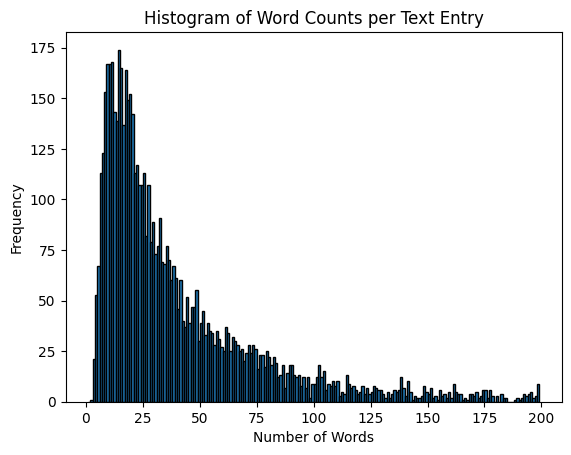

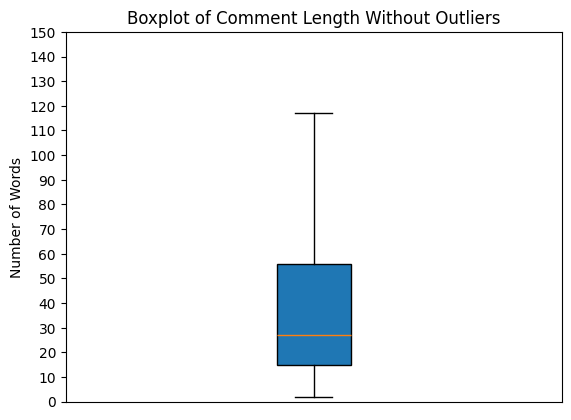

In [19]:
# Calculate the number of words per comment
df_filtered_text_descriptive = df_filtered_text_keywordfiltered_and_cleaned
df_filtered_text_descriptive['word_count'] = df_filtered_text_descriptive['comment_text'].apply(lambda x: len(x.split()))

# Plot the histogram of the distribution of word length
plt.hist(df_filtered_text_descriptive['word_count'], bins=range(1, 200), edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts per Text Entry')
plt.show()

# Plot a boxplot showing mean, median and quartiles of comment length as well as outliers
plt.boxplot(df_filtered_text_descriptive['word_count'], patch_artist=True, showfliers=False)

# Customize x-axis labels
max_word_count = df_filtered_text_descriptive['word_count'].max()
plt.yticks(range(0, max_word_count + 10, 10))
plt.ylim(0, 150)
# Remove y-axis labels
plt.xticks([])

plt.ylabel('Number of Words')
plt.title('Boxplot of Comment Length Without Outliers')
plt.show()

### Mean Word Lenght and P-Value

In [40]:
df_descriptive_analysis['word_count'] = df_descriptive_analysis['comment_text'].apply(lambda x: len(x.split()))
df_filtered_text_descriptive['word_count'] = df_filtered_text_descriptive['comment_text'].apply(lambda x: len(x.split()))

mean_word_count_all = df_descriptive_analysis['word_count'].mean()
mean_word_count_filtered = df_filtered_text_descriptive['word_count'].mean()

std_word_count_all = df_descriptive_analysis['word_count'].std()
std_word_count_filtered = df_filtered_text_descriptive['word_count'].std()

# Perfomr t-test
t_stat, p_value = ttest_ind(df_descriptive_analysis['word_count'], df_filtered_text_descriptive['word_count'], equal_var=False)

# Display the results
print(f'Mean Word Count for All Comments: {mean_word_count_all:.2f}')
print(f'Standard Deviation for All Comments: {std_word_count_all:.2f}')
print(f'Mean Word Count for Filtered Comments: {mean_word_count_filtered:.2f}')
print(f'Standard Deviation for Filtered Comments: {std_word_count_filtered:.2f}')
print(f'T-statistic: {t_stat:.2f}')
print(f'P-value: {p_value}')

# Interpretation
alpha = 0.05
if p_value < alpha:
    print('The difference in mean word counts between the two groups is statistically significant.')
else:
    print('The difference in mean word counts between the two groups is not statistically significant.')

Mean Word Count for All Comments: 30.41
Standard Deviation for All Comments: 48.90
Mean Word Count for Filtered Comments: 48.79
Standard Deviation for Filtered Comments: 70.58
T-statistic: -19.14
P-value: 5.367382356042105e-80
The difference in mean word counts between the two groups is statistically significant.


/var/folders/k1/f7fqjhfj6psgylqzzqh20nh80000gn/T/ipykernel_32696/1838261722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_text_descriptive['word_count'] = df_filtered_text_descriptive['comment_text'].apply(lambda x: len(x.split()))
